In [1]:
ls -gh /project2/macs30123/AWS_book_reviews/

total 17G
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_0.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_1.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_2.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_3.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_4.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_5.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_6.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_7.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_8.csv
-rw-rw-r-- 1 macs30123 1.7G Nov 10  2020 book_review_9.csv


In [2]:
from pyspark.sql.functions import *

In [3]:
data = spark.read.csv('/project2/macs30123/AWS_book_reviews/*.csv',
                      header='true',
                      inferSchema='true')

In [4]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())

Total Columns: 15
Total Rows: 20726160


In [5]:
data = (data.withColumn('star_rating', col('star_rating').cast('int'))
            .withColumn('total_votes', col('total_votes').cast('int'))
            .withColumn('helpful_votes', col('helpful_votes').cast('int'))
       )
data.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- year: string (nullable = true)



In [6]:
stars_votes = (data.groupBy('star_rating')
                   .sum('total_votes', 'helpful_votes')
                   .sort('star_rating', ascending=False)
              )
stars_votes.show()

+-----------+----------------+------------------+
|star_rating|sum(total_votes)|sum(helpful_votes)|
+-----------+----------------+------------------+
|         10|               5|              null|
|          5|        54772802|          44796242|
|          4|        13946766|          11094517|
|          3|        10113149|           7019293|
|          2|         9006573|           5579123|
|          1|        22610642|          10978974|
|          0|              81|              null|
|       null|           43088|             33089|
+-----------+----------------+------------------+



In [7]:
data.show(4)

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+--------------------+--------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|         review_date|                year|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+--------------------+--------------------+
|         US|   10799436|R1P0AGLUZRUVY0|0761134662|     649915147|The Big Book of B...|          3|           15|         19|   N|                Y|Could be better, ...|Firstly, with a t...|          2012-06-28|                2012|
|         FR|   17754411|  R4LUX6NCUZO5|2501081897|      36900727|  

## Q2: Engineering Good/Bad Labels

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# good >=4
# bad   <3
from pyspark.sql.functions import when, col

data = data.withColumn("label", when(col("star_rating") >= 4, 1).otherwise(0))

In [10]:
# print distribution of labels
(data.groupBy('label')
     .count()
     .show()
)

+-----+--------+
|label|   count|
+-----+--------+
|    1|17197641|
|    0| 3528519|
+-----+--------+



In [11]:
labels = data.groupBy('label').count().toPandas()

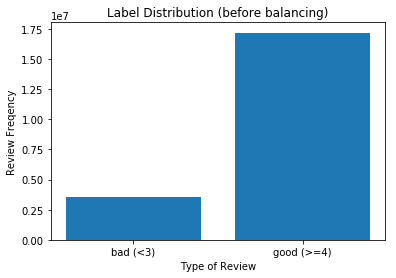

In [12]:
plt.close('all')
x = labels['label'].values
y = labels['count'].values
plt.title('Label Distribution (before balancing)')
plt.bar(x, y)
plt.xlabel('Type of Review')
plt.ylabel('Review Freqency')
plt.xticks(x, ['good (>=4)', 'bad (<3)']);

In [13]:
# undersampling good reviews
from pyspark.sql.functions import col

good = data.filter(col('label') == 1)
bad = data.filter(col('label') == 0)

# sample ratio
ratio = bad.count() / good.count()

In [14]:
# sample good reviews
sample_good = good.sampleBy("label", fractions={1: ratio}, seed=42)

# create balanced dataset with sampled data
data_bal = bad.union(sample_good)

In [15]:
# print label distribution -- Good balance!
(data_bal.groupBy('label')
     .count()
     .show()
)

+-----+-------+
|label|  count|
+-----+-------+
|    1|3528420|
|    0|3528519|
+-----+-------+



In [16]:
labels_bal = data_bal.groupBy('label').count().toPandas()

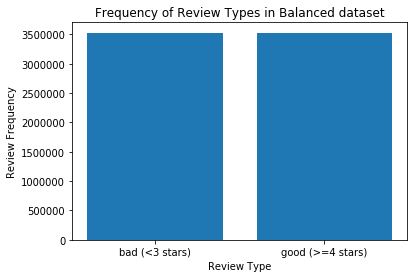

In [17]:
plt.close('all')
x = labels_bal['label'].values
y = labels_bal['count'].values
plt.title("Frequency of Review Types in Balanced dataset")
plt.bar(x, y)
plt.xlabel('Review Type')
plt.ylabel('Review Frequency')
plt.xticks(x, ['good (>=4 stars)', 'bad (<3 stars)']);

## Question 3. Implementing a Reproducible Machine Learning Pipeline

In [18]:
# recall columns
data.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- label: integer (nullable = false)



In [19]:
# print one row to understand what each is
data.show(2)

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+-----+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|year|label|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+-----+
|         US|   10799436|R1P0AGLUZRUVY0|0761134662|     649915147|The Big Book of B...|          3|           15|         19|   N|                Y|Could be better, ...|Firstly, with a t...| 2012-06-28|2012|    0|
|         FR|   17754411|  R4LUX6NCUZO5|2501081897|      36900727|       Jardin secret|          5|            0|          0|   N|              

In [20]:
# subsample data
data_bal_sample = data_bal.sample(fraction = 0.001, seed=42)

In [21]:
# feature one: helpful votes >10 and verified purchase
data_bal_sample = data_bal_sample.withColumn("help_dummy", when(col("helpful_votes") >= 5, 1).otherwise(0))
data_bal_sample = data_bal_sample.withColumn("ver_dummy", when(col("verified_purchase") == 'Y', 1).otherwise(0))
data_bal_sample = data_bal_sample.withColumn("helpful_and_verified", when((col("ver_dummy") == 1) & (col("help_dummy") == 1), 1).otherwise(0))

In [22]:
# check this worked
data_bal_sample.select('helpful_votes', 'help_dummy', 
                       'verified_purchase',
                       'ver_dummy', 'helpful_and_verified').show()

+-------------+----------+-----------------+---------+--------------------+
|helpful_votes|help_dummy|verified_purchase|ver_dummy|helpful_and_verified|
+-------------+----------+-----------------+---------+--------------------+
|            2|         0|                N|        0|                   0|
|            1|         0|                Y|        1|                   0|
|            0|         0|                Y|        1|                   0|
|            0|         0|                Y|        1|                   0|
|            1|         0|                N|        0|                   0|
|            0|         0|                Y|        1|                   0|
|            0|         0|                N|        0|                   0|
|            6|         1|                Y|        1|                   1|
|            0|         0|                N|        0|                   0|
|            0|         0|                Y|        1|                   0|
|           

In [23]:
# feature 2: length of review
from pyspark.sql.functions import length

data_bal_sample = data_bal_sample.withColumn('length', length(col('review_body')))

In [24]:
# check this worked
data_bal_sample.select('length', 'review_body').show()

+------+--------------------+
|length|         review_body|
+------+--------------------+
|  1311|While Claire is c...|
|   414|you'd only be int...|
|    24|excellent prophet...|
|    54|Interesting but p...|
|   213|"This book starte...|
|   298|The book was basi...|
|   515|Book was publishe...|
|   699|"This book is by ...|
|   347|To Heaven and Bac...|
|   238|I hate that this ...|
|  1176|"This is by no me...|
|   260|I was hoping this...|
|   184|How can a pastor ...|
|   449|"Bought the book,...|
|    76|loved part of thi...|
|    61|This book is fact...|
|   725|I've been trying ...|
|     7|             no good|
|   239|I WAS DISAPPOINTE...|
|  1017|If I had to rate ...|
+------+--------------------+
only showing top 20 rows



In [46]:
# feature 3: positive sentiment in review words
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

pos_words = ['fun', 'engaged', 'engaging', 'good', 'great', 'excellent', 
                  'amazing', 'fantastic', 'love', 'loved', 'best', 'beautiful',
                 'remarkable', 'tremendous', 'incredible', 'outstanding', 
             'extraordinary', 'happy', 'joy', 'smile', 'laugh']

def count_pos_words(text):
    if text:
        text_lower = text.lower()
        return sum(word in text_lower for word in pos_words)
    else:
        return 0
count_pos = udf(count_pos_words, IntegerType())

data_bal_sample = data_bal_sample.withColumn('pos_words_review', count_pos(col('review_body')))

In [47]:
# feature 4: positive sentiment in review headline
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

pos_words = ['fun', 'engaged', 'engaging', 'good', 'great', 'excellent', 
                  'amazing', 'fantastic', 'love', 'loved', 'best', 'beautiful',
                 'remarkable', 'tremendous', 'incredible', 'outstanding', 
             'extraordinary', 'happy', 'joy', 'smile', 'laugh']

def count_pos_words(text):
    if text:
        text_lower = text.lower()
        return sum(word in text_lower for word in pos_words)
    else:
        return 0
count_pos = udf(count_pos_words, IntegerType())

data_bal_sample = data_bal_sample.withColumn('pos_words_head', count_pos(col('review_headline')))

### 3b

In [49]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [51]:
# assemble pipeline
features = ['total_votes', 'helpful_votes', 'helpful_and_verified',
            'length', 'pos_words_review', 'pos_words_head']
assembler = VectorAssembler(inputCols=features, outputCol='features')

lr = LogisticRegression(featuresCol='features', labelCol='label')

pipeline = Pipeline(stages=[assembler, lr])

In [53]:
# data split
train, test = data_bal_sample.randomSplit([0.7, 0.3])

In [54]:
# fit on training data
pipeline_model = pipeline.fit(train)

Py4JJavaError: An error occurred while calling o634.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 22 in stage 45.0 failed 1 times, most recent failure: Lost task 22.0 in stage 45.0 (TID 2489, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-41-d5331cb18234>", line 12, in count_positive_words
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/sql/functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:520)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:494)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:489)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:279)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-41-d5331cb18234>", line 12, in count_positive_words
  File "/software/spark-2.4.3-el7-x86_64/python/lib/pyspark.zip/pyspark/sql/functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
# predictions
test_predictions = pipeline_model.transform(test)

In [ ]:
# confusion matrix
test_predictions.groupBy("label", "prediction").count().show()

In [ ]:
lr_model = pipeline_model.stages[-1]

In [ ]:
# Training Summary Data
trainingSummary = lr_model.summary

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
# calculate AUC
evaluator = BinaryClassificationEvaluator()
test_auc = evaluator.evaluate(test_predictions)

#calculate the accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(metricName="accuracy")
test_accuracy = evaluator_accuracy.evaluate(test_predictions)

In [ ]:
print(f"Training AUC: {trainingSummary.areaUnderROC}")
print(f"Test AUC: {test_auc}")

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print(f"label {i}, {rate}")

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print(f"label {i}, {rate}")
    
print(f"\nTraining Accuracy: {trainingSummary.accuracy}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Get ROC curve and send it to Pandas so that we can plot it
roc_df = lr_model.summary.roc.toPandas()

In [ ]:
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()